In [565]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.metrics import silhouette_score

In [566]:
def get_data(csv_file=''):
    return pd.read_csv(csv_file, sep=';')
    

In [567]:
data = get_data(csv_file='./dataset/data.csv')
data.head()



,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,01/12/09 07.45,"6,95",13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,01/12/09 07.45,"6,75",13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,01/12/09 07.45,"6,75",13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,01/12/09 07.45,"2,1",13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,01/12/09 07.45,"1,25",13085.0,United Kingdom


In [568]:
data.dtypes

Invoice         object
StockCode       object
Description     object
Quantity         int64
InvoiceDate     object
Price           object
Customer ID    float64
Country         object
dtype: object

In [569]:
def preprocess_data(data):
    data = data.dropna()
    data = data.drop_duplicates()
    data.columns = data.columns.str.strip()
    data = data.rename(columns={
        'Invoice': 'invoice',
        'StockCode': 'stock_code',
        'Description': 'description',
        'Quantity': 'quantity',
        'InvoiceDate': 'invoice_date',
        'Price': 'price',
        'Customer ID': 'customer_id',
        'Country': 'country'
    })
    
    data["customer_id"] = data["customer_id"].astype(str).str.replace('.0', '')
    data["invoice_date"] = pd.to_datetime(data["invoice_date"], format='%d/%m/%y %H.%M')
    data["price"] = data["price"].str.replace(',', '.').astype(float)
    data["quantity"] = pd.to_numeric(data["quantity"]).astype(float)
    data = data[data["quantity"] >= 0]
    return data

In [570]:
data = preprocess_data(data)
data.head()


,invoice,stock_code,description,quantity,invoice_date,price,customer_id,country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085,United Kingdom


In [571]:
data.dtypes

invoice                 object
stock_code              object
description             object
quantity                 int64
invoice_date    datetime64[ns]
price                  float64
customer_id             object
country                 object
dtype: object

In [572]:
def detect_outliers_zscore(data, threshold=3):
    z_scores = np.abs(stats.zscore(data.select_dtypes(include=[np.number])))
    outliers = (z_scores > threshold).any(axis=1)
    return outliers, z_scores

In [573]:
def detect_outliers_iqr(data, column):
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    print(f'Lower bound: {lower_bound}, Upper bound: {upper_bound}')
    return (data[column] < lower_bound) | (data[column] > upper_bound)

In [574]:
def remove_outliers(data, outliers):
    return data[~outliers]

In [575]:
def plot_boxplot(data, columns=[]):
    plt.figure(figsize=(12, 6))
    for i, column in enumerate(columns):
        plt.subplot(1, len(columns), i + 1)
        sns.boxplot(y=data[column])
        plt.title(f'Box Plot {column}')
    plt.tight_layout()
    plt.show()

In [576]:
def plot_scatter_with_outliers(data, x, y, outliers):
    plt.figure(figsize=(10, 6))
    sns.scatterplot(data=data, x=x, y=y, hue=outliers, palette={False: 'blue', True: 'red'})
    plt.title('Scatter Plot with Outliers: {} vs. {}'.format(x, y))
    plt.xlabel(x)
    plt.ylabel(y)
    plt.legend(title='Outlier')
    plt.show()

In [577]:
# 
outliers_quantity = detect_outliers_iqr(data, 'quantity')
outliers_price = detect_outliers_iqr(data, 'price')


Lower bound: -13.0, Upper bound: 27.0
Lower bound: -2.5, Upper bound: 7.5


In [578]:
# z_score

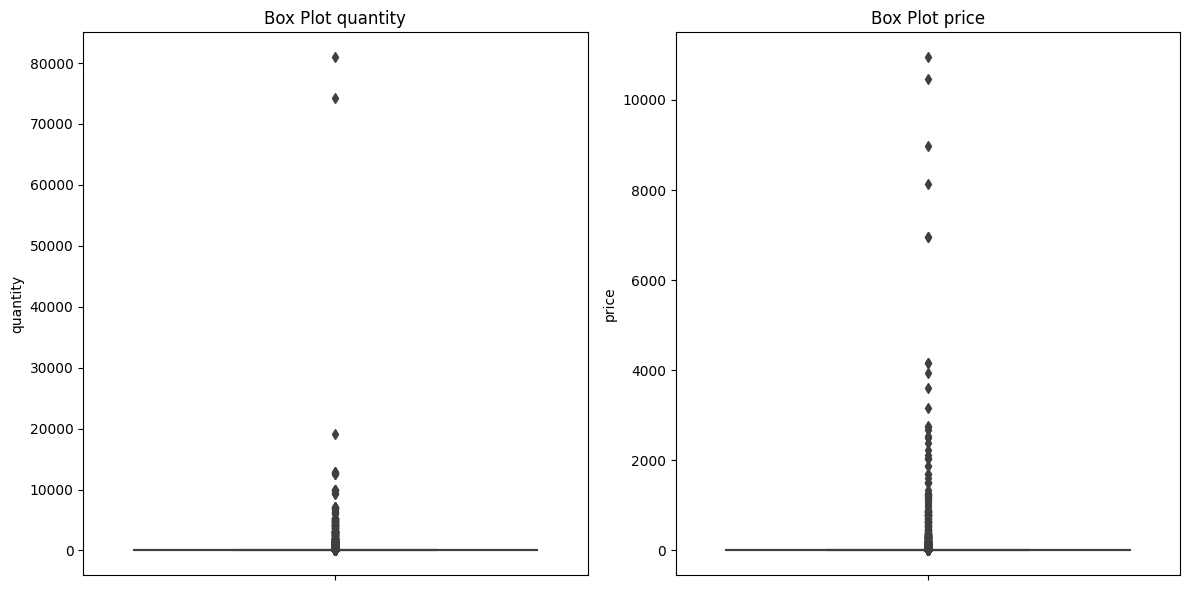

In [579]:
plot_boxplot(data, columns=['quantity', 'price'])

In [580]:
# plot_scatter_with_outliers(data, x='quantity', y='price', outliers=outliers)

In [581]:
def plot_data_before_after(data_before, data_after, columns):
    fig, axes = plt.subplots(2, len(columns), figsize=(15, 10))

    for i, column in enumerate(columns):
        sns.boxplot(data=data_before, y=column, ax=axes[0, i])
        axes[0, i].set_title(f'Before removing outliers: {column}')
        
        sns.boxplot(data=data_after, y=column, ax=axes[1, i])
        axes[1, i].set_title(f'After removing outliers: {column}')

    plt.tight_layout()
    plt.show()


In [582]:
# outliers
data_before = data.copy()
data_before

,invoice,stock_code,description,quantity,invoice_date,price,customer_id,country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085,United Kingdom
...,...,...,...,...,...,...,...,...
1044843,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,12680,France
1044844,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,12680,France
1044845,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.15,12680,France
1044846,581587,22138,BAKING SET 9 PIECE RETROSPOT,3,2011-12-09 12:50:00,4.95,12680,France


In [583]:
data = data[~(outliers_quantity | outliers_price)]
data

,invoice,stock_code,description,quantity,invoice_date,price,customer_id,country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085,United Kingdom
5,489434,22064,PINK DOUGHNUT TRINKET POT,24,2009-12-01 07:45:00,1.65,13085,United Kingdom
...,...,...,...,...,...,...,...,...
1044842,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,2011-12-09 12:50:00,0.85,12680,France
1044843,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,12680,France
1044844,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,12680,France
1044845,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.15,12680,France


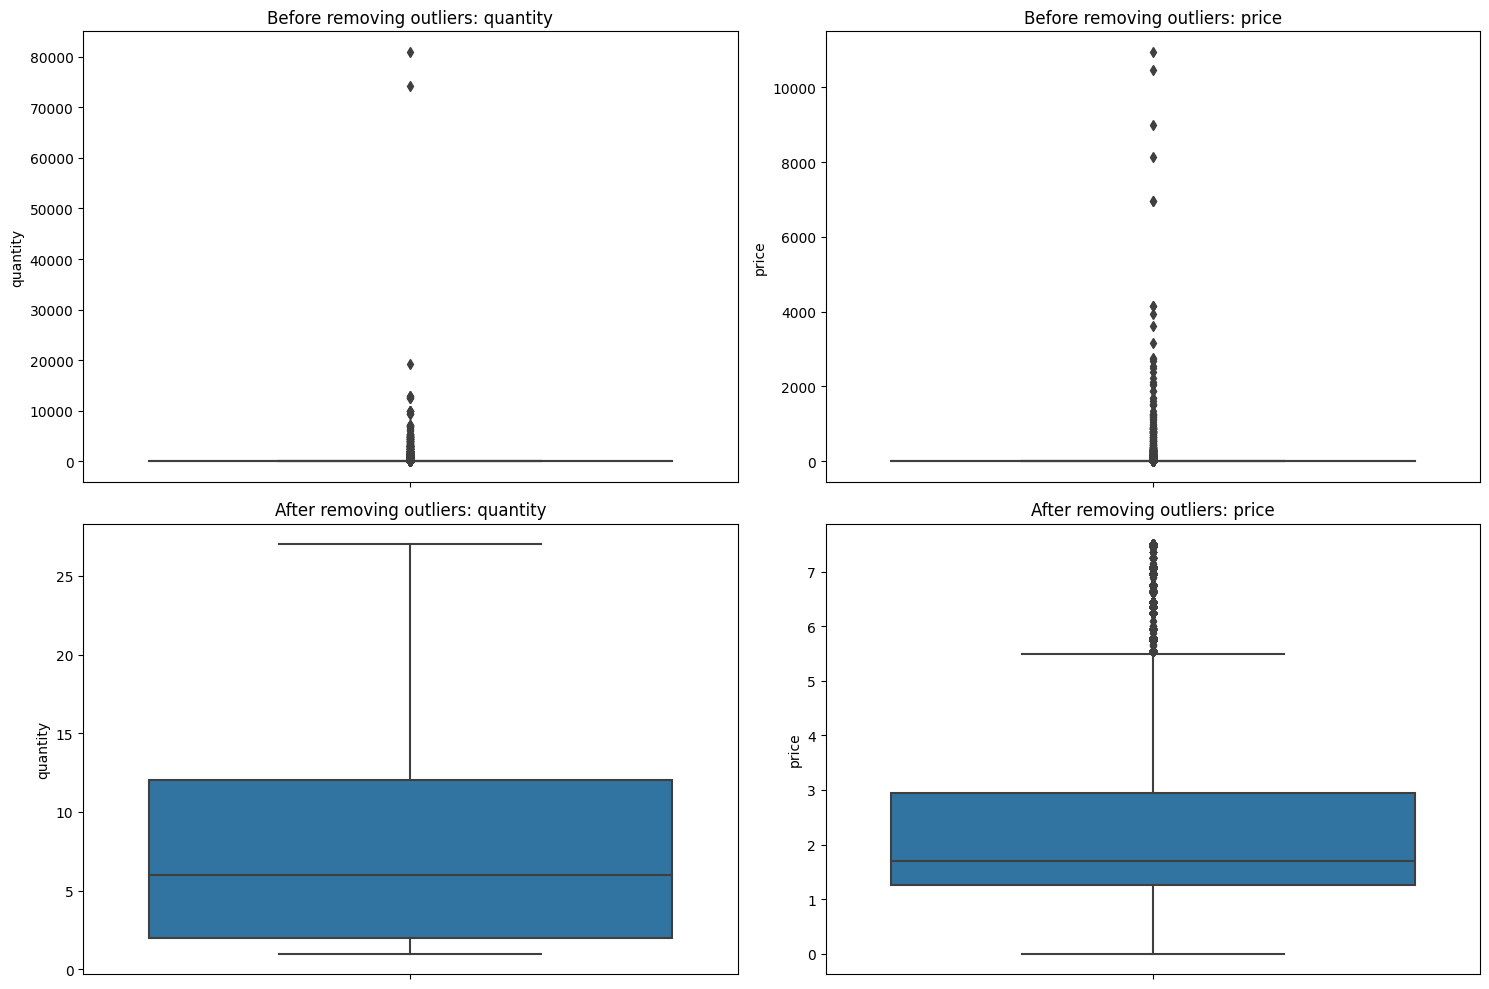

In [584]:
plot_data_before_after(data_before, data, columns=['quantity', 'price'])

In [585]:
def feature_extraction(data):
    data['total_price'] = data['quantity'] * data['price']
    customer_data = data.groupby('customer_id').agg({
        'invoice': 'nunique',  
        'quantity': 'sum',  
        'total_price': 'sum'  
    }).reset_index()
    customer_data.columns = ['customer_id', 'total_transaction', 'total_quantity', 'total_price']
    return customer_data


In [586]:
data = feature_extraction(data)
data

,customer_id,total_transaction,total_quantity,total_price
0,12346,11,70,372.86
1,12347,8,2399,3888.01
2,12348,4,513,312.36
3,12349,3,1421,2635.04
4,12350,1,196,294.40
...,...,...,...,...
5674,18283,22,1663,2511.25
5675,18284,1,215,286.88
5676,18285,1,56,93.20
5677,18286,2,525,1051.57


In [587]:
def plot_distribution(data, columns=[]):
    plt.figure(figsize=(12, 6))
    for i, column in enumerate(columns):
        plt.subplot(1, len(columns), i + 1)
        plt.hist(data[column], bins=50, density=True, alpha=0.3, color='teal', edgecolor='black')
        plt.title(f'Distribusi {column}')
        plt.xlabel(column)
        plt.ylabel('Density')
    plt.tight_layout()
    plt.show()

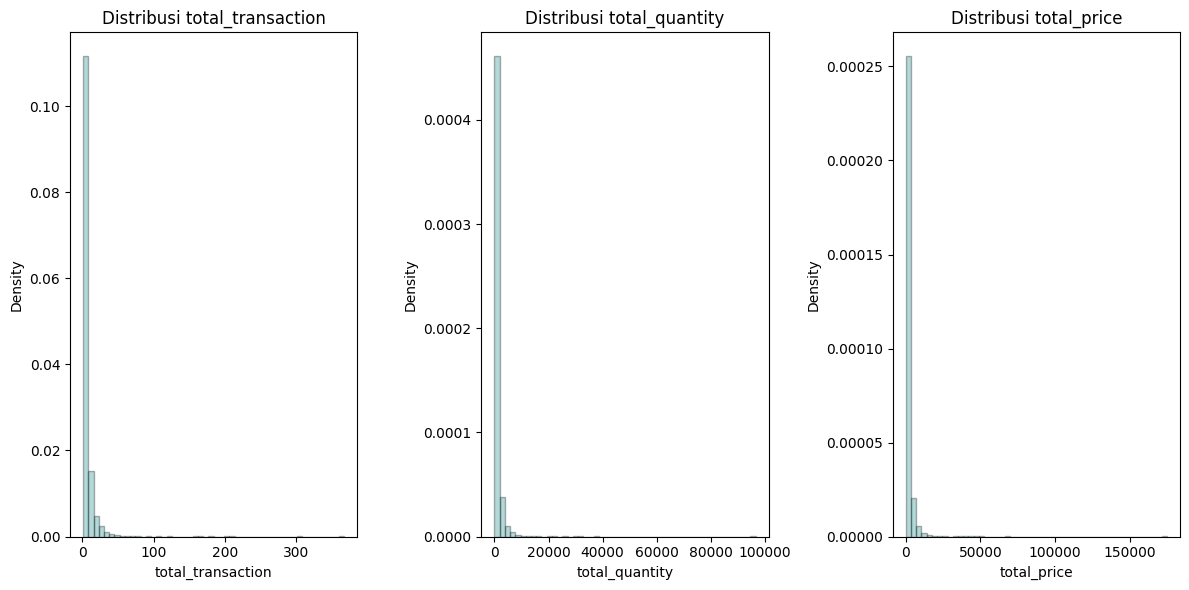

In [588]:
plot_distribution(data, columns=['total_transaction', 'total_quantity', 'total_price'])

In [589]:
data['total_transaction'] = np.log1p(data['total_transaction'])
data['total_quantity'] = np.log1p(data['total_quantity'])
data['total_price'] = np.log1p(data['total_price'])

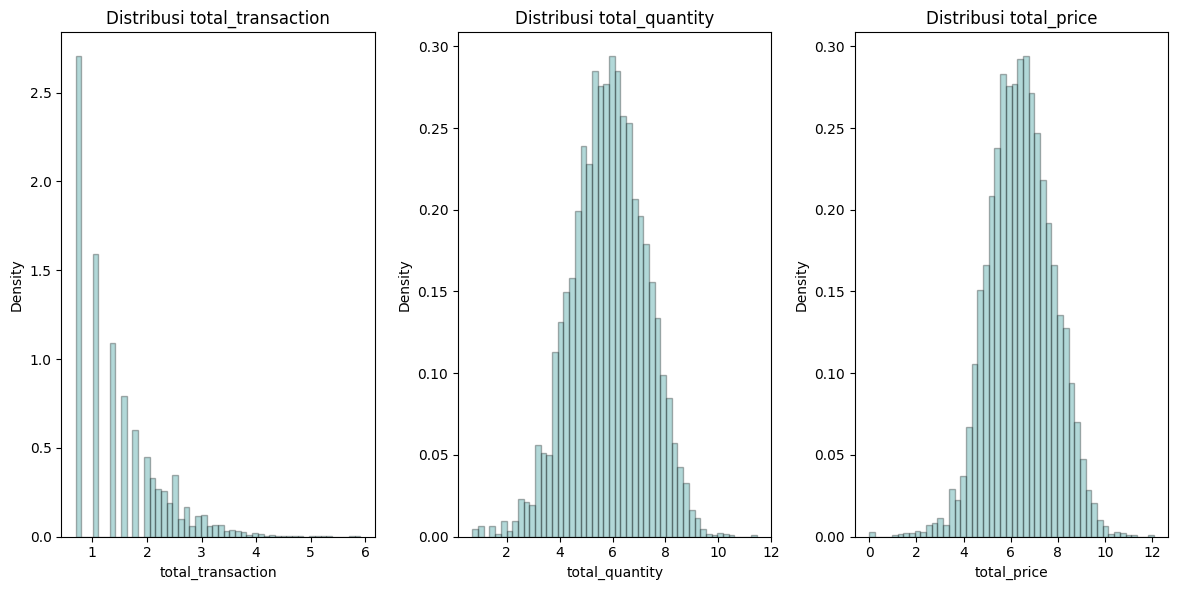

In [590]:
plot_distribution(data, columns=['total_transaction', 'total_quantity', 'total_price'])

In [591]:
def normalize_data(data, standard_features=[], minmax_features=[]):
    customer_ids = data['customer_id']
    data = data.drop('customer_id', axis=1)
    
    standard_scaler = StandardScaler()
    minmax_scaler = MinMaxScaler()
    
    if len(standard_features) > 0 and len(minmax_features) > 0:
        data_standard = standard_scaler.fit_transform(data[standard_features])
        data_minmax = minmax_scaler.fit_transform(data[minmax_features])
        
        data_standard_df = pd.DataFrame(data_standard, columns=standard_features)
        data_minmax_df = pd.DataFrame(data_minmax, columns=minmax_features)
        
        data_normalized = pd.concat([data_standard_df, data_minmax_df], axis=1)
        data_normalized['customer_id'] = customer_ids.reset_index(drop=True)
        
        return data_normalized
    elif len(standard_features) > 0:
        data_standard = standard_scaler.fit_transform(data[standard_features])
        data_standard_df = pd.DataFrame(data_standard, columns=standard_features)
        data_normalized = pd.concat([data[data.columns.difference(standard_features)], data_standard_df], axis=1)
        data_normalized['customer_id'] = customer_ids.reset_index(drop=True)
        
        return data_normalized
    elif len(minmax_features) > 0:
        data_minmax = minmax_scaler.fit_transform(data[minmax_features])
        data_minmax_df = pd.DataFrame(data_minmax, columns=minmax_features)
        data_normalized = pd.concat([data[data.columns.difference(minmax_features)], data_minmax_df], axis=1)
        data_normalized['customer_id'] = customer_ids.reset_index(drop=True)
        
        return data_normalized
    
    return data

In [592]:
# standard_features = ['total_quantity', 'total_price']
minmax_features = ['total_transaction','total_quantity', 'total_price']

data = normalize_data(data, minmax_features=minmax_features)
data

,total_transaction,total_quantity,total_price,customer_id
0,0.343582,0.330985,0.490714,12346
1,0.288417,0.657427,0.684720,12347
2,0.175705,0.514538,0.476091,12348
3,0.132916,0.608894,0.652507,12349
4,0.000000,0.425613,0.471202,12350
...,...,...,...,...
5674,0.468337,0.623467,0.648522,18283
5675,0.000000,0.434150,0.469066,18284
5676,0.000000,0.310620,0.376527,18285
5677,0.077751,0.516678,0.576459,18286


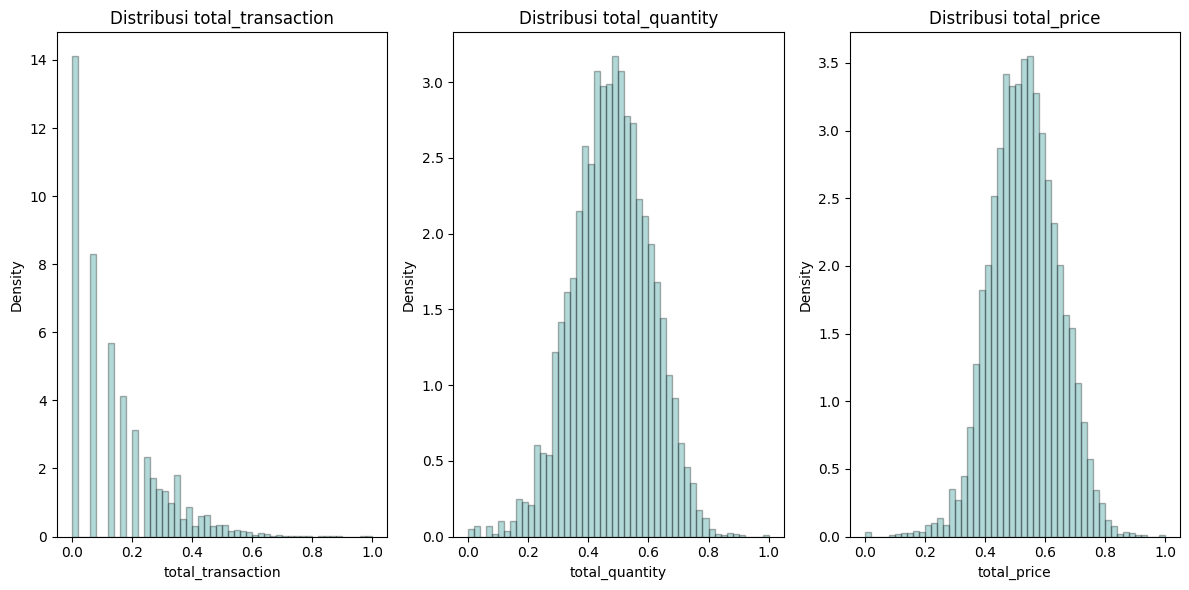

In [593]:
plot_distribution(data, columns=['total_transaction', 'total_quantity', 'total_price'])

In [594]:
def get_num_cluster_from_elbow(data):
    # standrd elbow
    # data_for_clustering = data.drop('customer_id', axis=1)
    # inertia = []
    # K = range(1, 11)
    # for k in K:
    #     kmeans = KMeans(n_clusters=k, random_state=0).fit(data_for_clustering)
    #     inertia.append(kmeans.inertia_)
    
    # plt.figure(figsize=(10, 6))
    # plt.plot(K, inertia, 'bo-')
    # plt.xlabel('Number of clusters')
    # plt.ylabel('Inertia')
    # plt.title('Elbow Method For Optimal Clusters')
    # plt.grid(True)
    # plt.show()

    data_for_clustering = data.drop('customer_id', axis=1)
    inertia = []
    K = range(1, 6)
    for k in K:
        kmeans = KMeans(n_clusters=k, random_state=0).fit(data_for_clustering)
        inertia.append(kmeans.inertia_)
    
    mean_distortion = np.array(inertia) / len(data_for_clustering)
    
    angles = []
    for i in range(1, len(mean_distortion) - 1):
        a = np.array([i, mean_distortion[i-1]])
        b = np.array([i+1, mean_distortion[i]])
        c = np.array([i+2, mean_distortion[i+1]])
        
        ab = b - a
        bc = c - b
        
        cosine_angle = np.dot(ab, bc) / (np.linalg.norm(ab) * np.linalg.norm(bc))
        angle = np.arccos(cosine_angle)
        angles.append(angle)
    
    optimal_k = np.argmin(angles) + 2  
    
    plt.figure(figsize=(10, 6))
    plt.plot(K, inertia, 'bo-')
    plt.axvline(x=optimal_k, color='r', linestyle='--')
    plt.xlabel('Number of clusters')
    plt.ylabel('Inertia')
    plt.title('Elbow Method For Optimal Clusters')
    plt.grid(True)
    plt.show()
    
    print(f'Optimal number of clusters: {optimal_k}')
    return optimal_k

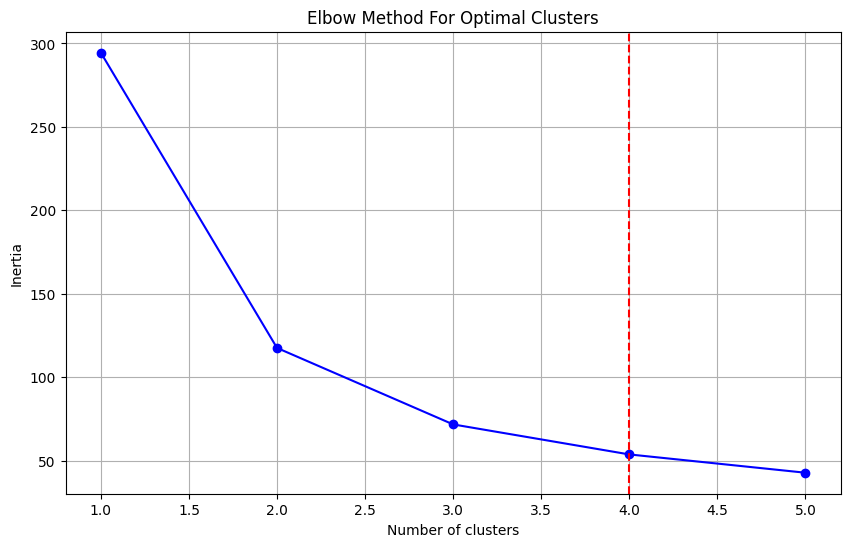

Optimal number of clusters: 4


In [595]:
n_cluster = get_num_cluster_from_elbow(data)

In [596]:
def clustering(data, n_clusters=3):
    kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(data.drop('customer_id', axis=1))
    data['cluster'] = kmeans.labels_
    centroids = kmeans.cluster_centers_
    return data, centroids

In [597]:

data, data_centroids = clustering(data, n_clusters=n_cluster)
data.head()

,total_transaction,total_quantity,total_price,customer_id,cluster
0,0.343582,0.330985,0.490714,12346,2
1,0.288417,0.657427,0.684720,12347,1
2,0.175705,0.514538,0.476091,12348,3
3,0.132916,0.608894,0.652507,12349,2
4,0.000000,0.425613,0.471202,12350,3


In [598]:
def visualize_cluster(data, x, y, centroid_x, centroid_y):
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x=x, y=y, hue='cluster', data=data, palette='muted', style='cluster', s=50)
    plt.scatter(centroid_x, centroid_y, s=200, c='red')
    plt.title('Customer Segments: {} vs. {}'.format(x, y))
    plt.xlabel(x)
    plt.ylabel(y)
    plt.legend(title='Cluster')
    plt.show()

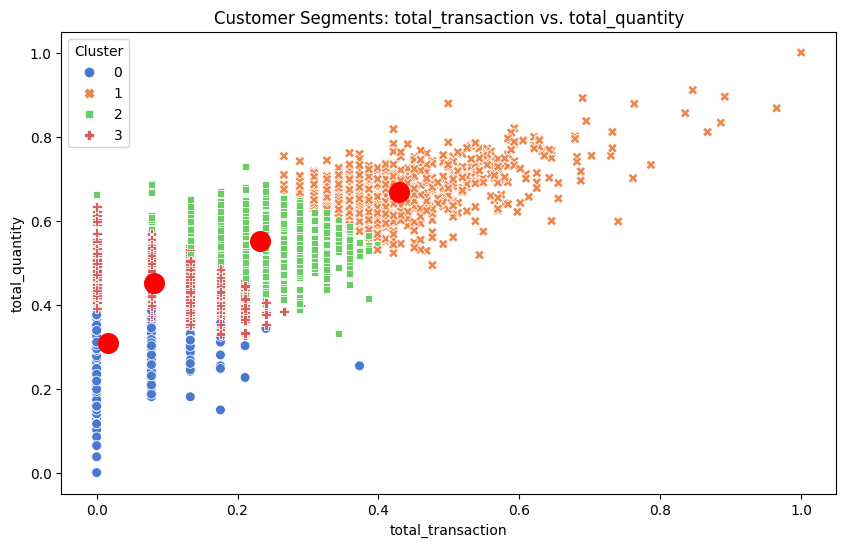

In [599]:
visualize_cluster(data, 'total_transaction', 'total_quantity', data_centroids[:, 0], data_centroids[:, 1])

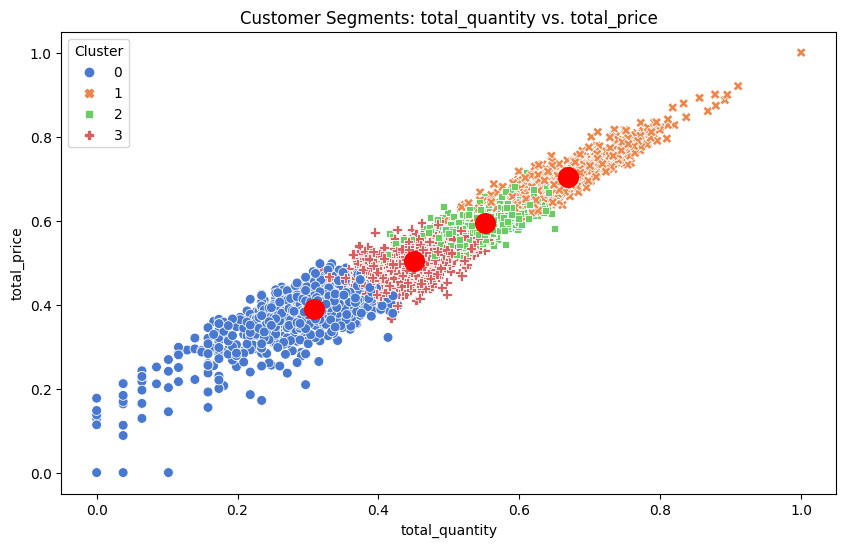

In [600]:
visualize_cluster(data,'total_quantity', 'total_price',data_centroids[:, 1], data_centroids[:, 2])

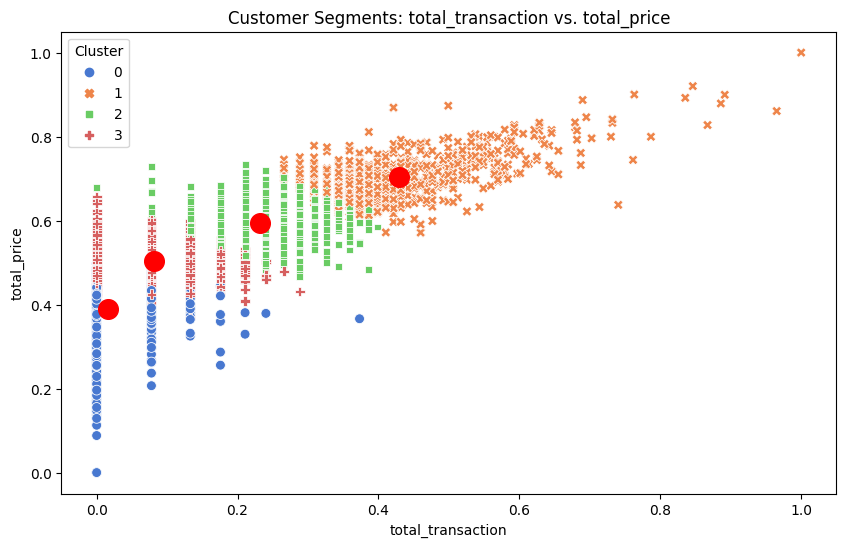

In [601]:
visualize_cluster(data, 'total_transaction', 'total_price',data_centroids[:, 0], data_centroids[:, 2])

In [602]:
score = silhouette_score(data.drop('customer_id', axis=1), data['cluster'])
print(f'Silhouette Score: {score}')

Silhouette Score: 0.8895332314869014
